# Municipal Boundaries in the Americas

This example will use data from GeoBoundaries.org's data set of [Comprehensive Global Administrative Zones (CGAZ)] (https://www.geoboundaries.org/globalDownloads.html).

> CGAZ is a set of global composites for administrative boundaries. There are two important distinctions between our global product and individual country downloads. First, extensive simplification is performed to ensure that file sizes are small enough to be used in most traditional desktop software. Second, disputed areas are removed and replaced with polygons following US Department of State definitions.
> Attribution: www.geoboundaries.org

*Note*: This notebook incurs downloading a 360MB file. To successfully follow this example, please ensure sufficient storage space. The time to download this data will vary based on internet connection speed. We've added a download progress bar to the data retrieval section of this notebook to allow you to view progress and a time estimate for downloading the visualization data.

## Imports

In [ ]:
! pip install pyogrio lonboard requests pyarrow geopandas tqdm shapely

In [1]:
import requests
import lonboard
import shapely
from lonboard import SolidPolygonLayer, PathLayer, Map
import geopandas as gpd
import pyogrio
from tqdm import tqdm

- The URL for a large data file of CGAZ at ADM1 Districts level.

In [2]:

# URL of the GeoJSON file
url = "https://github.com/wmgeolab/geoBoundaries/raw/main/releaseData/CGAZ/geoBoundariesCGAZ_ADM1.geojson"
filepath = "geoBoundariesCGAZ_ADM1.geojson"

We'll go ahead and fetch the geojson data in that format

In [3]:
# Make a GET request to download the file
# Streaming, so we can iterate over the response and create a progress bar for this large file
response = requests.get(url, stream=True)

# Sizes in bytes.
total_size = int(response.headers.get("content-length", 0))
block_size = 1024

with tqdm(total=total_size, unit="B", unit_scale=True) as progress_bar:
    with open(filepath, "wb") as file:
        for data in response.iter_content(block_size):
            progress_bar.update(len(data))
            file.write(data)

if total_size != 0 and progress_bar.n != total_size:
    raise RuntimeError("Could not download file")

100%|████████████████████████████████████████████████████████████████████████████████████████████████| 361M/361M [05:11<00:00, 1.16MB/s]


## Visualize Global Boundaries
In this demonstration, we will visualize the entire data set of ~3224 global administrative boundaries for our visualization.

In [4]:
# Use pyogrio engine for an optimization of the time it takes to read this file
# We will also enable use_arrow, for speed

gdf = gpd.read_file(f"./{filepath}",engine='pyogrio',use_arrow=True)

# Keep columns necessary for our visualization
cols = ['shapeName','shapeID','geometry']

gdf = gdf[cols]

We can take a quick look at this data before visualizing.

In [5]:
gdf.head(10)

,shapeName,shapeID,geometry
0,Kandahar,12653393B40111500734429,"POLYGON ((65.24153 32.28630, 65.12687 32.03679..."
1,Zabul,12653393B56617740339660,"POLYGON ((67.60666 31.44378, 67.70162 31.51373..."
2,Uruzgan,12653393B46006342616872,"POLYGON ((66.27519 32.42550, 66.35907 32.60925..."
3,Daykundi,12653393B78791504725813,"POLYGON ((66.76157 33.25547, 66.92827 33.59694..."
4,Ghanzi,12653393B29313712249365,"POLYGON ((68.06945 32.04564, 68.06011 32.45619..."
5,Paktika,12653393B93572570471663,"MULTIPOLYGON (((68.10797 31.74752, 68.10807 31..."
6,Khost,12653393B66876919073955,"POLYGON ((69.50619 33.02954, 69.50620 33.02954..."
7,Paktia,12653393B16859990709200,"POLYGON ((68.76070 33.41986, 68.95811 33.18136..."
8,Logar,12653393B769191277822,"POLYGON ((68.78347 33.62259, 68.99623 33.62635..."
9,Wardak,12653393B94990201402617,"POLYGON ((68.68691 33.72585, 68.86023 34.01301..."


## Preparing the data for our Map

In this demonstration, we want to end up with a pickable map of global municipal boundaries with nice looking borders around municipal areas so that we can see the boundaries, regardless of whether they're being activately picked.
To accomplish that, we'll create a lonboard `PathLayer` along with our `SolidPolygonLayer`

Our dataset contains both `Polygon` and `MultiPolygon` geometries. Using the `shapely` library we can quickly obtain boundaries from both geometry types.

In [6]:
ms_and_kdh = gdf[gdf['shapeName'].isin(['Mississippi','Kandahar'])]
ms_and_kdh

,shapeName,shapeID,geometry
0,Kandahar,12653393B40111500734429,"POLYGON ((65.24153 32.28630, 65.12687 32.03679..."
98,Mississippi,66186276B69138566591314,"MULTIPOLYGON (((-88.77009 30.24290, -88.75279 ..."


Here is an example of viewing an individual geometry.

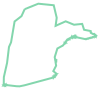

In [7]:
gdf.iloc[0]['geometry'].boundary

## Creating a GeoDataFrame of Boundaries

Now that we have a way to get the boundary of Polygons and MultiPolygons, let's use those boundaries to create a GeoDataFrame of the geometry boundaries.

In [8]:
# Step 1: Calculate 'boundary' for each geometry using shapely.boundary()
# Instead of adding it to the original gdf, directly create a new GeoSeries
boundaries = shapely.boundary(gdf['geometry'])

# Step 2: Create a new GeoDataFrame from the boundaries GeoSeries, 
# explicitly setting it as the 'geometry' column
boundary_gdf = gpd.GeoDataFrame(geometry=boundaries)

Let's take a look at the Boundaries GeoDataFrame

In [9]:
boundary_gdf.head()

,geometry
0,"LINESTRING (65.24153 32.28630, 65.12687 32.036..."
1,"LINESTRING (67.60666 31.44378, 67.70162 31.513..."
2,"LINESTRING (66.27519 32.42550, 66.35907 32.609..."
3,"LINESTRING (66.76157 33.25547, 66.92827 33.596..."
4,"LINESTRING (68.06945 32.04564, 68.06011 32.456..."


## Combining SolidPolygonLayer and PathLayer 
Now let's create a lonboard `PathLayer` from the `boundary` column of `LineString` and `MultiLineString` geometries

In [10]:
# set up our fill and line colors
fill_rgb = [204, 251, 254] # light blue
border_rgb = [37, 36, 34] # dark border color

In [18]:
borders_layer = PathLayer.from_geopandas(
    boundary_gdf,
    get_color=border_rgb,
    get_width=2,
    width_min_pixels=1
)

In [ ]:
polygon_layer = SolidPolygonLayer.from_geopandas(
    gdf,
    auto_highlight=True,
    extruded=True,
    filled=False,
    get_fill_color=fill_rgb,
    get_line_color=border_rgb,
    wireframe=True,
    pickable=True
)

In [19]:
map_ = Map(layers=[polygon_layer,borders_layer])

In [ ]:
# visualize the map
map_

![all of global municipal boundaries, focus Prime Meridian](../assets/all-global-boundaries.png)